# **_Práctica 7_**
---

In [10]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [11]:
datos = pd.read_excel("../P7/Iberdrola2010-24.xls")
datos

,Fecha,cerrar
0,2010-01-04,6.5276
1,2010-01-05,6.5354
2,2010-01-06,6.5267
3,2010-01-07,6.4850
4,2010-01-08,6.4782
...,...,...
3817,2024-11-20,13.3500
3818,2024-11-21,13.3250
3819,2024-11-22,13.5850
3820,2024-11-25,13.4000


Hipótesis de que el valor al cierre va a depender sólo de los 20 anteriores

In [12]:
def prepare_dataframe_for_series(df,n_steps):
    df = dc(df)

    df.set_index('Fecha', inplace=True) # Inplace para modificar el dataframe o crear una nuevo.

    for i in range(1, n_steps+1):
        df[f'Cierre(t-{i})'] = df['cerrar'].shift(i)
    df.dropna(inplace=True)
    
    return df

In [13]:
lookback = 20
shifted_df = prepare_dataframe_for_series(datos, lookback)
shifted_df

,cerrar,Cierre(t-1),Cierre(t-2),Cierre(t-3),Cierre(t-4),Cierre(t-5),Cierre(t-6),Cierre(t-7),Cierre(t-8),Cierre(t-9),...,Cierre(t-11),Cierre(t-12),Cierre(t-13),Cierre(t-14),Cierre(t-15),Cierre(t-16),Cierre(t-17),Cierre(t-18),Cierre(t-19),Cierre(t-20)
Fecha,,,,,,,,,,,,,,,,,,,,,
2010-02-01,6.0145,5.9942,5.9612,6.0747,6.1571,6.0912,6.1610,6.2192,6.3046,6.4530,...,6.3822,6.4665,6.4753,6.4743,6.4791,6.4782,6.4850,6.5267,6.5354,6.5276
2010-02-02,6.0660,6.0145,5.9942,5.9612,6.0747,6.1571,6.0912,6.1610,6.2192,6.3046,...,6.4142,6.3822,6.4665,6.4753,6.4743,6.4791,6.4782,6.4850,6.5267,6.5354
2010-02-03,6.0078,6.0660,6.0145,5.9942,5.9612,6.0747,6.1571,6.0912,6.1610,6.2192,...,6.4530,6.4142,6.3822,6.4665,6.4753,6.4743,6.4791,6.4782,6.4850,6.5267
2010-02-04,5.7245,6.0078,6.0660,6.0145,5.9942,5.9612,6.0747,6.1571,6.0912,6.1610,...,6.3046,6.4530,6.4142,6.3822,6.4665,6.4753,6.4743,6.4791,6.4782,6.4850
2010-02-05,5.6644,5.7245,6.0078,6.0660,6.0145,5.9942,5.9612,6.0747,6.1571,6.0912,...,6.2192,6.3046,6.4530,6.4142,6.3822,6.4665,6.4753,6.4743,6.4791,6.4782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20,13.3500,13.4000,13.3300,13.3900,13.3700,13.2050,13.1850,13.3650,13.2100,13.1100,...,13.7450,13.7200,13.8250,13.6450,13.7600,13.9100,14.0700,13.9500,14.0250,14.0400
2024-11-21,13.3250,13.3500,13.4000,13.3300,13.3900,13.3700,13.2050,13.1850,13.3650,13.2100,...,13.1650,13.7450,13.7200,13.8250,13.6450,13.7600,13.9100,14.0700,13.9500,14.0250
2024-11-22,13.5850,13.3250,13.3500,13.4000,13.3300,13.3900,13.3700,13.2050,13.1850,13.3650,...,13.1100,13.1650,13.7450,13.7200,13.8250,13.6450,13.7600,13.9100,14.0700,13.9500


In [14]:
X = shifted_df.iloc[:,1:].values
y = shifted_df.iloc[:,0].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.33, random_state=42)

In [16]:
X_train = torch.unsqueeze(torch.from_numpy(X_train1).to(torch.float32), dim=-1)
X_test = torch.unsqueeze(torch.from_numpy(X_test1).to(torch.float32), dim=-1)
y_train = torch.unsqueeze(torch.from_numpy(y_train1).to(torch.float32), dim=-1)
y_test = torch.unsqueeze(torch.from_numpy(y_test1).to(torch.float32), dim=-1)

### Red de Elman 2 capas ocultas 5 neuronas

In [17]:
class Elman(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers = 1, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.hidden_layer = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, h = self.hidden_layer(x,h0)
        output = self.output_layer(out[:,-1,:])
        return output

In [18]:
input_size = 1  
hidden_size = 5
output_size = 5
num_layers = 2

model = Elman(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model
summary(model, (20,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 20, 5], [-1, 2, 5]]               0
            Linear-2                    [-1, 5]              30
Total params: 30
Trainable params: 30
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [19]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]

In [21]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)


In [22]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0

    for x_batch, y_batch in tqdm(train_loader):
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()  # convierte el tensor de perdida a un escalar

        optimizer.zero_grad()  # reinicia los gradientes de los parametros del modelo
        loss.backward()  #  calcula los gradientes de la perdida con respecto a los parametros del modelo
        optimizer.step()  # actualiza los parametros utilizando el optimizador y los gradientes calculados.

    return running_loss / len(train_loader)

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for x_batch, y_batch in test_loader:
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    return running_loss / len(test_loader)

In [25]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    val_loss = validate_one_epoch()
    print(f'Train Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 1


  0%|          | 0/160 [00:00<?, ?it/s]/home/pablo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 95%|█████████▌| 152/160 [00:01<00:00, 144.61it/s]/home/pablo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 160/160 [00:01<00:00, 126.93it/s]
/home/pablo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7, 1])) that is d

Train Loss: 55.2054 Validation Loss: 46.3764
Epoch: 2


100%|██████████| 160/160 [00:01<00:00, 152.86it/s]


Train Loss: 41.8810 Validation Loss: 34.9522
Epoch: 3


100%|██████████| 160/160 [00:01<00:00, 148.42it/s]


Train Loss: 32.0087 Validation Loss: 26.7446
Epoch: 4


100%|██████████| 160/160 [00:01<00:00, 146.60it/s]


Train Loss: 24.6459 Validation Loss: 20.6491
Epoch: 5


100%|██████████| 160/160 [00:01<00:00, 149.55it/s]


Train Loss: 19.2811 Validation Loss: 16.1485
Epoch: 6


100%|██████████| 160/160 [00:01<00:00, 117.80it/s]


Train Loss: 15.1595 Validation Loss: 12.9767
Epoch: 7


100%|██████████| 160/160 [00:01<00:00, 135.06it/s]


Train Loss: 12.5046 Validation Loss: 10.8042
Epoch: 8


100%|██████████| 160/160 [00:01<00:00, 134.44it/s]


Train Loss: 10.5092 Validation Loss: 9.3110
Epoch: 9


100%|██████████| 160/160 [00:01<00:00, 136.41it/s]


Train Loss: 9.1913 Validation Loss: 8.3282
Epoch: 10


100%|██████████| 160/160 [00:01<00:00, 117.91it/s]


Train Loss: 8.3260 Validation Loss: 7.7791
Epoch: 11


100%|██████████| 160/160 [00:01<00:00, 121.16it/s]


Train Loss: 7.5338 Validation Loss: 5.9450
Epoch: 12


100%|██████████| 160/160 [00:01<00:00, 151.12it/s]


Train Loss: 5.3960 Validation Loss: 4.4981
Epoch: 13


100%|██████████| 160/160 [00:01<00:00, 149.34it/s]


Train Loss: 4.1473 Validation Loss: 3.4967
Epoch: 14


100%|██████████| 160/160 [00:01<00:00, 145.18it/s]


Train Loss: 3.2351 Validation Loss: 2.7301
Epoch: 15


100%|██████████| 160/160 [00:01<00:00, 154.45it/s]


Train Loss: 2.4928 Validation Loss: 2.1181
Epoch: 16


100%|██████████| 160/160 [00:01<00:00, 152.85it/s]


Train Loss: 1.9430 Validation Loss: 1.6603
Epoch: 17


100%|██████████| 160/160 [00:01<00:00, 158.93it/s]


Train Loss: 1.5128 Validation Loss: 1.3027
Epoch: 18


100%|██████████| 160/160 [00:01<00:00, 138.91it/s]


Train Loss: 1.2141 Validation Loss: 1.0525
Epoch: 19


100%|██████████| 160/160 [00:01<00:00, 153.88it/s]


Train Loss: 0.9605 Validation Loss: 0.8567
Epoch: 20


100%|██████████| 160/160 [00:01<00:00, 131.56it/s]


Train Loss: 0.7847 Validation Loss: 0.7065
Epoch: 21


100%|██████████| 160/160 [00:01<00:00, 154.77it/s]


Train Loss: 0.6288 Validation Loss: 0.5627
Epoch: 22


100%|██████████| 160/160 [00:01<00:00, 158.09it/s]


Train Loss: 0.5195 Validation Loss: 0.4795
Epoch: 23


100%|██████████| 160/160 [00:01<00:00, 158.61it/s]


Train Loss: 0.4333 Validation Loss: 0.3971
Epoch: 24


100%|██████████| 160/160 [00:00<00:00, 163.48it/s]


Train Loss: 0.3725 Validation Loss: 0.3605
Epoch: 25


100%|██████████| 160/160 [00:01<00:00, 159.33it/s]


Train Loss: 0.3383 Validation Loss: 0.3103
Epoch: 26


100%|██████████| 160/160 [00:00<00:00, 162.94it/s]


Train Loss: 0.2864 Validation Loss: 0.2860
Epoch: 27


100%|██████████| 160/160 [00:01<00:00, 151.55it/s]


Train Loss: 0.2565 Validation Loss: 0.2647
Epoch: 28


100%|██████████| 160/160 [00:00<00:00, 160.67it/s]


Train Loss: 0.2302 Validation Loss: 0.2404
Epoch: 29


100%|██████████| 160/160 [00:00<00:00, 163.01it/s]


Train Loss: 0.2177 Validation Loss: 0.2120
Epoch: 30


100%|██████████| 160/160 [00:01<00:00, 159.97it/s]


Train Loss: 0.1982 Validation Loss: 0.2087
Epoch: 31


100%|██████████| 160/160 [00:01<00:00, 147.62it/s]


Train Loss: 0.1795 Validation Loss: 0.1822
Epoch: 32


100%|██████████| 160/160 [00:01<00:00, 153.89it/s]


Train Loss: 0.1680 Validation Loss: 0.1743
Epoch: 33


100%|██████████| 160/160 [00:00<00:00, 162.79it/s]


Train Loss: 0.1573 Validation Loss: 0.1614
Epoch: 34


100%|██████████| 160/160 [00:01<00:00, 155.67it/s]


Train Loss: 0.1454 Validation Loss: 0.1467
Epoch: 35


100%|██████████| 160/160 [00:01<00:00, 160.00it/s]


Train Loss: 0.1353 Validation Loss: 0.1386
Epoch: 36


100%|██████████| 160/160 [00:01<00:00, 156.82it/s]


Train Loss: 0.1253 Validation Loss: 0.1241
Epoch: 37


100%|██████████| 160/160 [00:01<00:00, 136.46it/s]


Train Loss: 0.1122 Validation Loss: 0.1251
Epoch: 38


100%|██████████| 160/160 [00:01<00:00, 126.51it/s]


Train Loss: 0.1025 Validation Loss: 0.1071
Epoch: 39


100%|██████████| 160/160 [00:01<00:00, 155.30it/s]


Train Loss: 0.0970 Validation Loss: 0.0962
Epoch: 40


100%|██████████| 160/160 [00:00<00:00, 161.64it/s]


Train Loss: 0.0876 Validation Loss: 0.0947
Epoch: 41


100%|██████████| 160/160 [00:01<00:00, 140.20it/s]


Train Loss: 0.0841 Validation Loss: 0.0849
Epoch: 42


100%|██████████| 160/160 [00:00<00:00, 162.57it/s]


Train Loss: 0.0755 Validation Loss: 0.0938
Epoch: 43


100%|██████████| 160/160 [00:01<00:00, 159.23it/s]


Train Loss: 0.0735 Validation Loss: 0.0754
Epoch: 44


100%|██████████| 160/160 [00:01<00:00, 149.82it/s]


Train Loss: 0.0700 Validation Loss: 0.0721
Epoch: 45


100%|██████████| 160/160 [00:01<00:00, 142.44it/s]


Train Loss: 0.0634 Validation Loss: 0.0664
Epoch: 46


100%|██████████| 160/160 [00:01<00:00, 156.81it/s]


Train Loss: 0.0636 Validation Loss: 0.0674
Epoch: 47


100%|██████████| 160/160 [00:00<00:00, 165.56it/s]


Train Loss: 0.0592 Validation Loss: 0.0617
Epoch: 48


100%|██████████| 160/160 [00:01<00:00, 155.85it/s]


Train Loss: 0.0567 Validation Loss: 0.0584
Epoch: 49


100%|██████████| 160/160 [00:00<00:00, 161.14it/s]


Train Loss: 0.0551 Validation Loss: 0.0542
Epoch: 50


100%|██████████| 160/160 [00:01<00:00, 157.51it/s]


Train Loss: 0.0534 Validation Loss: 0.0520
Epoch: 51


100%|██████████| 160/160 [00:00<00:00, 161.10it/s]


Train Loss: 0.0535 Validation Loss: 0.0602
Epoch: 52


100%|██████████| 160/160 [00:01<00:00, 154.08it/s]


Train Loss: 0.0490 Validation Loss: 0.0519
Epoch: 53


100%|██████████| 160/160 [00:01<00:00, 144.15it/s]


Train Loss: 0.0488 Validation Loss: 0.0457
Epoch: 54


100%|██████████| 160/160 [00:01<00:00, 146.44it/s]


Train Loss: 0.0477 Validation Loss: 0.0580
Epoch: 55


100%|██████████| 160/160 [00:00<00:00, 160.08it/s]


Train Loss: 0.0494 Validation Loss: 0.0417
Epoch: 56


100%|██████████| 160/160 [00:00<00:00, 163.99it/s]


Train Loss: 0.0427 Validation Loss: 0.0433
Epoch: 57


100%|██████████| 160/160 [00:01<00:00, 150.19it/s]


Train Loss: 0.0446 Validation Loss: 0.0387
Epoch: 58


100%|██████████| 160/160 [00:01<00:00, 156.17it/s]


Train Loss: 0.0404 Validation Loss: 0.0391
Epoch: 59


100%|██████████| 160/160 [00:01<00:00, 156.65it/s]


Train Loss: 0.0415 Validation Loss: 0.0466
Epoch: 60


100%|██████████| 160/160 [00:01<00:00, 155.70it/s]


Train Loss: 0.0442 Validation Loss: 0.0377
Epoch: 61


100%|██████████| 160/160 [00:01<00:00, 159.46it/s]


Train Loss: 0.0398 Validation Loss: 0.0366
Epoch: 62


100%|██████████| 160/160 [00:00<00:00, 161.03it/s]


Train Loss: 0.0425 Validation Loss: 0.0357
Epoch: 63


100%|██████████| 160/160 [00:00<00:00, 162.21it/s]


Train Loss: 0.0383 Validation Loss: 0.0373
Epoch: 64


100%|██████████| 160/160 [00:01<00:00, 156.62it/s]


Train Loss: 0.0409 Validation Loss: 0.0361
Epoch: 65


100%|██████████| 160/160 [00:01<00:00, 158.99it/s]


Train Loss: 0.0398 Validation Loss: 0.0482
Epoch: 66


100%|██████████| 160/160 [00:01<00:00, 156.43it/s]


Train Loss: 0.0398 Validation Loss: 0.0442
Epoch: 67


100%|██████████| 160/160 [00:01<00:00, 143.58it/s]


Train Loss: 0.0387 Validation Loss: 0.0398
Epoch: 68


100%|██████████| 160/160 [00:01<00:00, 156.58it/s]


Train Loss: 0.0393 Validation Loss: 0.0334
Epoch: 69


100%|██████████| 160/160 [00:01<00:00, 159.59it/s]


Train Loss: 0.0367 Validation Loss: 0.0327
Epoch: 70


100%|██████████| 160/160 [00:01<00:00, 144.07it/s]


Train Loss: 0.0388 Validation Loss: 0.0396
Epoch: 71


100%|██████████| 160/160 [00:01<00:00, 157.73it/s]


Train Loss: 0.0408 Validation Loss: 0.0469
Epoch: 72


100%|██████████| 160/160 [00:01<00:00, 158.14it/s]


Train Loss: 0.0367 Validation Loss: 0.0340
Epoch: 73


100%|██████████| 160/160 [00:00<00:00, 160.34it/s]


Train Loss: 0.0372 Validation Loss: 0.0406
Epoch: 74


100%|██████████| 160/160 [00:01<00:00, 159.09it/s]


Train Loss: 0.0355 Validation Loss: 0.0341
Epoch: 75


100%|██████████| 160/160 [00:00<00:00, 160.55it/s]


Train Loss: 0.0347 Validation Loss: 0.0408
Epoch: 76


100%|██████████| 160/160 [00:00<00:00, 162.85it/s]


Train Loss: 0.0393 Validation Loss: 0.0317
Epoch: 77


100%|██████████| 160/160 [00:01<00:00, 158.20it/s]


Train Loss: 0.0388 Validation Loss: 0.0364
Epoch: 78


100%|██████████| 160/160 [00:00<00:00, 162.53it/s]


Train Loss: 0.0351 Validation Loss: 0.0380
Epoch: 79


100%|██████████| 160/160 [00:01<00:00, 153.82it/s]


Train Loss: 0.0368 Validation Loss: 0.0505
Epoch: 80


100%|██████████| 160/160 [00:01<00:00, 156.71it/s]


Train Loss: 0.0362 Validation Loss: 0.0303
Epoch: 81


100%|██████████| 160/160 [00:01<00:00, 159.01it/s]


Train Loss: 0.0350 Validation Loss: 0.0322
Epoch: 82


100%|██████████| 160/160 [00:01<00:00, 153.32it/s]


Train Loss: 0.0352 Validation Loss: 0.0381
Epoch: 83


100%|██████████| 160/160 [00:01<00:00, 158.19it/s]


Train Loss: 0.0392 Validation Loss: 0.0343
Epoch: 84


100%|██████████| 160/160 [00:01<00:00, 150.45it/s]


Train Loss: 0.0373 Validation Loss: 0.0314
Epoch: 85


100%|██████████| 160/160 [00:01<00:00, 158.82it/s]


Train Loss: 0.0379 Validation Loss: 0.0472
Epoch: 86


100%|██████████| 160/160 [00:01<00:00, 145.83it/s]


Train Loss: 0.0347 Validation Loss: 0.0321
Epoch: 87


100%|██████████| 160/160 [00:01<00:00, 157.26it/s]


Train Loss: 0.0339 Validation Loss: 0.0309
Epoch: 88


100%|██████████| 160/160 [00:01<00:00, 151.38it/s]


Train Loss: 0.0349 Validation Loss: 0.0433
Epoch: 89


100%|██████████| 160/160 [00:01<00:00, 153.14it/s]


Train Loss: 0.0387 Validation Loss: 0.0315
Epoch: 90


100%|██████████| 160/160 [00:01<00:00, 151.08it/s]


Train Loss: 0.0336 Validation Loss: 0.0301
Epoch: 91


100%|██████████| 160/160 [00:01<00:00, 155.51it/s]


Train Loss: 0.0376 Validation Loss: 0.0315
Epoch: 92


100%|██████████| 160/160 [00:01<00:00, 158.10it/s]


Train Loss: 0.0336 Validation Loss: 0.0337
Epoch: 93


100%|██████████| 160/160 [00:01<00:00, 141.56it/s]


Train Loss: 0.0360 Validation Loss: 0.0287
Epoch: 94


100%|██████████| 160/160 [00:01<00:00, 158.55it/s]


Train Loss: 0.0339 Validation Loss: 0.0348
Epoch: 95


100%|██████████| 160/160 [00:01<00:00, 110.80it/s]


Train Loss: 0.0339 Validation Loss: 0.0304
Epoch: 96


100%|██████████| 160/160 [00:01<00:00, 140.59it/s]


Train Loss: 0.0351 Validation Loss: 0.0294
Epoch: 97


100%|██████████| 160/160 [00:01<00:00, 158.32it/s]


Train Loss: 0.0367 Validation Loss: 0.0401
Epoch: 98


100%|██████████| 160/160 [00:01<00:00, 154.50it/s]


Train Loss: 0.0349 Validation Loss: 0.0648
Epoch: 99


100%|██████████| 160/160 [00:00<00:00, 160.62it/s]


Train Loss: 0.0332 Validation Loss: 0.0322
Epoch: 100


100%|██████████| 160/160 [00:01<00:00, 156.50it/s]


Train Loss: 0.0350 Validation Loss: 0.0294
Epoch: 101


100%|██████████| 160/160 [00:01<00:00, 152.70it/s]


Train Loss: 0.0353 Validation Loss: 0.0429
Epoch: 102


100%|██████████| 160/160 [00:01<00:00, 97.10it/s] 


Train Loss: 0.0339 Validation Loss: 0.0362
Epoch: 103


100%|██████████| 160/160 [00:01<00:00, 158.86it/s]


Train Loss: 0.0336 Validation Loss: 0.0485
Epoch: 104


100%|██████████| 160/160 [00:01<00:00, 125.73it/s]


Train Loss: 0.0361 Validation Loss: 0.0281
Epoch: 105


100%|██████████| 160/160 [00:01<00:00, 139.30it/s]


Train Loss: 0.0346 Validation Loss: 0.0421
Epoch: 106


100%|██████████| 160/160 [00:01<00:00, 151.40it/s]


Train Loss: 0.0359 Validation Loss: 0.0310
Epoch: 107


100%|██████████| 160/160 [00:01<00:00, 157.51it/s]


Train Loss: 0.0366 Validation Loss: 0.0315
Epoch: 108


100%|██████████| 160/160 [00:01<00:00, 156.63it/s]


Train Loss: 0.0331 Validation Loss: 0.0424
Epoch: 109


100%|██████████| 160/160 [00:01<00:00, 134.80it/s]


Train Loss: 0.0351 Validation Loss: 0.0282
Epoch: 110


100%|██████████| 160/160 [00:01<00:00, 120.12it/s]


Train Loss: 0.0339 Validation Loss: 0.0449
Epoch: 111


100%|██████████| 160/160 [00:01<00:00, 146.15it/s]


Train Loss: 0.0343 Validation Loss: 0.0375
Epoch: 112


100%|██████████| 160/160 [00:01<00:00, 150.56it/s]


Train Loss: 0.0325 Validation Loss: 0.0295
Epoch: 113


100%|██████████| 160/160 [00:01<00:00, 151.33it/s]


Train Loss: 0.0349 Validation Loss: 0.0326
Epoch: 114


100%|██████████| 160/160 [00:01<00:00, 132.30it/s]


Train Loss: 0.0332 Validation Loss: 0.0374
Epoch: 115


100%|██████████| 160/160 [00:01<00:00, 159.82it/s]


Train Loss: 0.0337 Validation Loss: 0.0284
Epoch: 116


100%|██████████| 160/160 [00:01<00:00, 155.72it/s]


Train Loss: 0.0336 Validation Loss: 0.0387
Epoch: 117


100%|██████████| 160/160 [00:01<00:00, 157.99it/s]


Train Loss: 0.0342 Validation Loss: 0.0316
Epoch: 118


100%|██████████| 160/160 [00:01<00:00, 156.48it/s]


Train Loss: 0.0311 Validation Loss: 0.0366
Epoch: 119


100%|██████████| 160/160 [00:01<00:00, 158.26it/s]


Train Loss: 0.0347 Validation Loss: 0.0326
Epoch: 120


100%|██████████| 160/160 [00:01<00:00, 158.08it/s]


Train Loss: 0.0324 Validation Loss: 0.0507
Epoch: 121


100%|██████████| 160/160 [00:01<00:00, 145.58it/s]


Train Loss: 0.0352 Validation Loss: 0.0497
Epoch: 122


100%|██████████| 160/160 [00:01<00:00, 159.22it/s]


Train Loss: 0.0320 Validation Loss: 0.0293
Epoch: 123


100%|██████████| 160/160 [00:01<00:00, 155.38it/s]


Train Loss: 0.0322 Validation Loss: 0.0296
Epoch: 124


100%|██████████| 160/160 [00:00<00:00, 163.62it/s]


Train Loss: 0.0327 Validation Loss: 0.0370
Epoch: 125


100%|██████████| 160/160 [00:01<00:00, 156.75it/s]


Train Loss: 0.0352 Validation Loss: 0.0372
Epoch: 126


100%|██████████| 160/160 [00:00<00:00, 164.55it/s]


Train Loss: 0.0329 Validation Loss: 0.0310
Epoch: 127


100%|██████████| 160/160 [00:00<00:00, 160.87it/s]


Train Loss: 0.0333 Validation Loss: 0.0279
Epoch: 128


100%|██████████| 160/160 [00:01<00:00, 150.78it/s]


Train Loss: 0.0350 Validation Loss: 0.0275
Epoch: 129


100%|██████████| 160/160 [00:00<00:00, 163.28it/s]


Train Loss: 0.0311 Validation Loss: 0.0282
Epoch: 130


100%|██████████| 160/160 [00:01<00:00, 158.00it/s]


Train Loss: 0.0329 Validation Loss: 0.0512
Epoch: 131


100%|██████████| 160/160 [00:00<00:00, 166.34it/s]


Train Loss: 0.0320 Validation Loss: 0.0270
Epoch: 132


100%|██████████| 160/160 [00:00<00:00, 161.35it/s]


Train Loss: 0.0333 Validation Loss: 0.0290
Epoch: 133


100%|██████████| 160/160 [00:00<00:00, 161.90it/s]


Train Loss: 0.0326 Validation Loss: 0.0359
Epoch: 134


100%|██████████| 160/160 [00:00<00:00, 162.57it/s]


Train Loss: 0.0342 Validation Loss: 0.0300
Epoch: 135


100%|██████████| 160/160 [00:00<00:00, 161.15it/s]


Train Loss: 0.0323 Validation Loss: 0.0304
Epoch: 136


100%|██████████| 160/160 [00:00<00:00, 162.24it/s]


Train Loss: 0.0345 Validation Loss: 0.0374
Epoch: 137


100%|██████████| 160/160 [00:00<00:00, 165.38it/s]


Train Loss: 0.0324 Validation Loss: 0.0288
Epoch: 138


100%|██████████| 160/160 [00:00<00:00, 162.91it/s]


Train Loss: 0.0320 Validation Loss: 0.0332
Epoch: 139


100%|██████████| 160/160 [00:00<00:00, 161.42it/s]


Train Loss: 0.0341 Validation Loss: 0.0346
Epoch: 140


100%|██████████| 160/160 [00:00<00:00, 160.23it/s]


Train Loss: 0.0340 Validation Loss: 0.0267
Epoch: 141


100%|██████████| 160/160 [00:00<00:00, 166.08it/s]


Train Loss: 0.0305 Validation Loss: 0.0519
Epoch: 142


100%|██████████| 160/160 [00:01<00:00, 149.73it/s]


Train Loss: 0.0324 Validation Loss: 0.0758
Epoch: 143


100%|██████████| 160/160 [00:01<00:00, 158.79it/s]


Train Loss: 0.0318 Validation Loss: 0.0274
Epoch: 144


100%|██████████| 160/160 [00:01<00:00, 147.95it/s]


Train Loss: 0.0317 Validation Loss: 0.0345
Epoch: 145


100%|██████████| 160/160 [00:00<00:00, 162.40it/s]


Train Loss: 0.0331 Validation Loss: 0.0314
Epoch: 146


100%|██████████| 160/160 [00:00<00:00, 166.72it/s]


Train Loss: 0.0323 Validation Loss: 0.0275
Epoch: 147


100%|██████████| 160/160 [00:01<00:00, 158.06it/s]


Train Loss: 0.0308 Validation Loss: 0.0270
Epoch: 148


100%|██████████| 160/160 [00:01<00:00, 159.81it/s]


Train Loss: 0.0310 Validation Loss: 0.0387
Epoch: 149


100%|██████████| 160/160 [00:01<00:00, 146.23it/s]


Train Loss: 0.0368 Validation Loss: 0.0297
Epoch: 150


100%|██████████| 160/160 [00:00<00:00, 166.46it/s]


Train Loss: 0.0305 Validation Loss: 0.0269
Epoch: 151


100%|██████████| 160/160 [00:01<00:00, 159.88it/s]


Train Loss: 0.0345 Validation Loss: 0.0446
Epoch: 152


100%|██████████| 160/160 [00:01<00:00, 158.00it/s]


Train Loss: 0.0331 Validation Loss: 0.0272
Epoch: 153


100%|██████████| 160/160 [00:00<00:00, 161.93it/s]


Train Loss: 0.0334 Validation Loss: 0.0303
Epoch: 154


100%|██████████| 160/160 [00:00<00:00, 162.41it/s]


Train Loss: 0.0333 Validation Loss: 0.0385
Epoch: 155


100%|██████████| 160/160 [00:00<00:00, 165.51it/s]


Train Loss: 0.0309 Validation Loss: 0.0505
Epoch: 156


100%|██████████| 160/160 [00:01<00:00, 148.56it/s]


Train Loss: 0.0308 Validation Loss: 0.0390
Epoch: 157


100%|██████████| 160/160 [00:00<00:00, 161.69it/s]


Train Loss: 0.0302 Validation Loss: 0.0273
Epoch: 158


100%|██████████| 160/160 [00:00<00:00, 163.89it/s]


Train Loss: 0.0298 Validation Loss: 0.0281
Epoch: 159


100%|██████████| 160/160 [00:00<00:00, 162.79it/s]


Train Loss: 0.0302 Validation Loss: 0.0255
Epoch: 160


100%|██████████| 160/160 [00:01<00:00, 149.41it/s]


Train Loss: 0.0313 Validation Loss: 0.0260
Epoch: 161


100%|██████████| 160/160 [00:00<00:00, 160.37it/s]


Train Loss: 0.0315 Validation Loss: 0.0347
Epoch: 162


100%|██████████| 160/160 [00:01<00:00, 155.31it/s]


Train Loss: 0.0292 Validation Loss: 0.0300
Epoch: 163


100%|██████████| 160/160 [00:00<00:00, 164.23it/s]


Train Loss: 0.0299 Validation Loss: 0.0262
Epoch: 164


100%|██████████| 160/160 [00:00<00:00, 162.65it/s]


Train Loss: 0.0307 Validation Loss: 0.0399
Epoch: 165


100%|██████████| 160/160 [00:00<00:00, 162.43it/s]


Train Loss: 0.0386 Validation Loss: 0.0314
Epoch: 166


100%|██████████| 160/160 [00:00<00:00, 163.09it/s]


Train Loss: 0.0301 Validation Loss: 0.0329
Epoch: 167


100%|██████████| 160/160 [00:00<00:00, 162.37it/s]


Train Loss: 0.0305 Validation Loss: 0.0288
Epoch: 168


100%|██████████| 160/160 [00:01<00:00, 154.64it/s]


Train Loss: 0.0299 Validation Loss: 0.0274
Epoch: 169


100%|██████████| 160/160 [00:01<00:00, 82.27it/s]


Train Loss: 0.0283 Validation Loss: 0.0255
Epoch: 170


100%|██████████| 160/160 [00:01<00:00, 129.64it/s]


Train Loss: 0.0313 Validation Loss: 0.0258
Epoch: 171


100%|██████████| 160/160 [00:01<00:00, 145.97it/s]


Train Loss: 0.0302 Validation Loss: 0.0263
Epoch: 172


100%|██████████| 160/160 [00:00<00:00, 161.24it/s]


Train Loss: 0.0292 Validation Loss: 0.0279
Epoch: 173


100%|██████████| 160/160 [00:01<00:00, 145.26it/s]


Train Loss: 0.0320 Validation Loss: 0.0277
Epoch: 174


100%|██████████| 160/160 [00:01<00:00, 135.85it/s]


Train Loss: 0.0307 Validation Loss: 0.0292
Epoch: 175


100%|██████████| 160/160 [00:00<00:00, 160.18it/s]


Train Loss: 0.0309 Validation Loss: 0.0324
Epoch: 176


100%|██████████| 160/160 [00:00<00:00, 165.94it/s]


Train Loss: 0.0323 Validation Loss: 0.0256
Epoch: 177


100%|██████████| 160/160 [00:01<00:00, 157.62it/s]


Train Loss: 0.0297 Validation Loss: 0.0280
Epoch: 178


100%|██████████| 160/160 [00:00<00:00, 164.22it/s]


Train Loss: 0.0294 Validation Loss: 0.0352
Epoch: 179


100%|██████████| 160/160 [00:01<00:00, 159.93it/s]


Train Loss: 0.0309 Validation Loss: 0.0256
Epoch: 180


100%|██████████| 160/160 [00:00<00:00, 161.83it/s]


Train Loss: 0.0278 Validation Loss: 0.0288
Epoch: 181


100%|██████████| 160/160 [00:01<00:00, 141.64it/s]


Train Loss: 0.0284 Validation Loss: 0.0303
Epoch: 182


100%|██████████| 160/160 [00:01<00:00, 122.46it/s]


Train Loss: 0.0283 Validation Loss: 0.0241
Epoch: 183


100%|██████████| 160/160 [00:00<00:00, 163.46it/s]


Train Loss: 0.0297 Validation Loss: 0.0409
Epoch: 184


100%|██████████| 160/160 [00:00<00:00, 161.26it/s]


Train Loss: 0.0292 Validation Loss: 0.0260
Epoch: 185


100%|██████████| 160/160 [00:01<00:00, 138.40it/s]


Train Loss: 0.0290 Validation Loss: 0.0252
Epoch: 186


100%|██████████| 160/160 [00:01<00:00, 154.64it/s]


Train Loss: 0.0293 Validation Loss: 0.0235
Epoch: 187


100%|██████████| 160/160 [00:01<00:00, 126.21it/s]


Train Loss: 0.0286 Validation Loss: 0.0259
Epoch: 188


100%|██████████| 160/160 [00:00<00:00, 163.01it/s]


Train Loss: 0.0282 Validation Loss: 0.0237
Epoch: 189


100%|██████████| 160/160 [00:01<00:00, 147.81it/s]


Train Loss: 0.0283 Validation Loss: 0.0263
Epoch: 190


100%|██████████| 160/160 [00:01<00:00, 149.56it/s]


Train Loss: 0.0279 Validation Loss: 0.0235
Epoch: 191


100%|██████████| 160/160 [00:01<00:00, 154.44it/s]


Train Loss: 0.0271 Validation Loss: 0.0243
Epoch: 192


100%|██████████| 160/160 [00:00<00:00, 166.85it/s]


Train Loss: 0.0286 Validation Loss: 0.0274
Epoch: 193


100%|██████████| 160/160 [00:01<00:00, 157.98it/s]


Train Loss: 0.0281 Validation Loss: 0.0273
Epoch: 194


100%|██████████| 160/160 [00:00<00:00, 161.36it/s]


Train Loss: 0.0278 Validation Loss: 0.0498
Epoch: 195


100%|██████████| 160/160 [00:01<00:00, 137.36it/s]


Train Loss: 0.0280 Validation Loss: 0.0272
Epoch: 196


100%|██████████| 160/160 [00:01<00:00, 157.60it/s]


Train Loss: 0.0272 Validation Loss: 0.0415
Epoch: 197


100%|██████████| 160/160 [00:01<00:00, 136.30it/s]


Train Loss: 0.0280 Validation Loss: 0.0373
Epoch: 198


100%|██████████| 160/160 [00:00<00:00, 162.63it/s]


Train Loss: 0.0277 Validation Loss: 0.0449
Epoch: 199


100%|██████████| 160/160 [00:00<00:00, 165.92it/s]


Train Loss: 0.0272 Validation Loss: 0.0252
Epoch: 200


100%|██████████| 160/160 [00:00<00:00, 164.07it/s]


Train Loss: 0.0289 Validation Loss: 0.0258


In [26]:
num_epochs = 100
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

for epoch in range(num_epochs):
    # Training
    model.train(True)
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0

    for x_batch, y_batch in tqdm(train_loader):
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train(False)

    # Accuracy and loss values for training dataset
    with torch.no_grad():
        y_train_predicted = model(X_train)
    train_loss.append(loss_function(y_train_predicted,y_train).numpy())
    train_accuracy.append(np.mean((torch.abs((y_train - y_train_predicted) / y_train).numpy() < 0.05)))
    print('Train Loss: {0:.5f}'.format(train_loss[-1]), '\tTrain Accuracy: {0:.5f}'.format(train_accuracy[-1]))

    # Accuracy and loss values for training dataset
    with torch.no_grad():
        y_test_predicted = model(X_test)
    test_loss.append(loss_function(y_test_predicted, y_test).numpy())
    test_accuracy.append(np.mean((torch.abs((y_test - y_test_predicted) / y_test).numpy() < 0.05)))
    print('Test Loss: {0:.5f}'.format(test_loss[-1]), '\tTest Accuracy: {0:.5f}'.format(test_accuracy[-1]))

Epoch: 1


100%|██████████| 160/160 [00:01<00:00, 155.41it/s]
/home/pablo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2547, 1])) that is different to the input size (torch.Size([2547, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pablo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1255, 1])) that is different to the input size (torch.Size([1255, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 0.02685 	Train Accuracy: 0.94503
Test Loss: 0.02685 	Test Accuracy: 0.93594
Epoch: 2


100%|██████████| 160/160 [00:01<00:00, 154.36it/s]


Train Loss: 0.02458 	Train Accuracy: 0.94935
Test Loss: 0.02371 	Test Accuracy: 0.94789
Epoch: 3


100%|██████████| 160/160 [00:01<00:00, 139.88it/s]


Train Loss: 0.02467 	Train Accuracy: 0.95626
Test Loss: 0.02372 	Test Accuracy: 0.94215
Epoch: 4


100%|██████████| 160/160 [00:01<00:00, 112.00it/s]


Train Loss: 0.02961 	Train Accuracy: 0.93765
Test Loss: 0.02977 	Test Accuracy: 0.92685
Epoch: 5


100%|██████████| 160/160 [00:01<00:00, 110.52it/s]


Train Loss: 0.04795 	Train Accuracy: 0.89195
Test Loss: 0.04513 	Test Accuracy: 0.88510
Epoch: 6


100%|██████████| 160/160 [00:01<00:00, 154.28it/s]


Train Loss: 0.02390 	Train Accuracy: 0.95053
Test Loss: 0.02318 	Test Accuracy: 0.94582
Epoch: 7


100%|██████████| 160/160 [00:01<00:00, 155.83it/s]


Train Loss: 0.02598 	Train Accuracy: 0.95014
Test Loss: 0.02571 	Test Accuracy: 0.93944
Epoch: 8


100%|██████████| 160/160 [00:01<00:00, 130.19it/s]


Train Loss: 0.02383 	Train Accuracy: 0.95556
Test Loss: 0.02357 	Test Accuracy: 0.93992
Epoch: 9


100%|██████████| 160/160 [00:01<00:00, 150.92it/s]


Train Loss: 0.04248 	Train Accuracy: 0.86117
Test Loss: 0.04319 	Test Accuracy: 0.86470
Epoch: 10


100%|██████████| 160/160 [00:01<00:00, 149.22it/s]


Train Loss: 0.02716 	Train Accuracy: 0.95281
Test Loss: 0.02531 	Test Accuracy: 0.95251
Epoch: 11


100%|██████████| 160/160 [00:01<00:00, 148.76it/s]


Train Loss: 0.02277 	Train Accuracy: 0.95870
Test Loss: 0.02200 	Test Accuracy: 0.94502
Epoch: 12


100%|██████████| 160/160 [00:01<00:00, 135.74it/s]


Train Loss: 0.02647 	Train Accuracy: 0.94660
Test Loss: 0.02646 	Test Accuracy: 0.93721
Epoch: 13


100%|██████████| 160/160 [00:00<00:00, 160.59it/s]


Train Loss: 0.02330 	Train Accuracy: 0.95241
Test Loss: 0.02250 	Test Accuracy: 0.94980
Epoch: 14


100%|██████████| 160/160 [00:01<00:00, 157.92it/s]


Train Loss: 0.03503 	Train Accuracy: 0.91849
Test Loss: 0.03551 	Test Accuracy: 0.90884
Epoch: 15


100%|██████████| 160/160 [00:01<00:00, 125.80it/s]


Train Loss: 0.03018 	Train Accuracy: 0.91991
Test Loss: 0.02998 	Test Accuracy: 0.91904
Epoch: 16


100%|██████████| 160/160 [00:01<00:00, 151.80it/s]


Train Loss: 0.02246 	Train Accuracy: 0.96168
Test Loss: 0.02142 	Test Accuracy: 0.95044
Epoch: 17


100%|██████████| 160/160 [00:01<00:00, 144.70it/s]


Train Loss: 0.02575 	Train Accuracy: 0.94605
Test Loss: 0.02510 	Test Accuracy: 0.93769
Epoch: 18


100%|██████████| 160/160 [00:01<00:00, 156.75it/s]


Train Loss: 0.02190 	Train Accuracy: 0.96160
Test Loss: 0.02090 	Test Accuracy: 0.95410
Epoch: 19


100%|██████████| 160/160 [00:01<00:00, 130.57it/s]


Train Loss: 0.02472 	Train Accuracy: 0.95391
Test Loss: 0.02456 	Test Accuracy: 0.94231
Epoch: 20


100%|██████████| 160/160 [00:01<00:00, 150.78it/s]


Train Loss: 0.02263 	Train Accuracy: 0.96090
Test Loss: 0.02193 	Test Accuracy: 0.94645
Epoch: 21


100%|██████████| 160/160 [00:01<00:00, 105.06it/s]


Train Loss: 0.04239 	Train Accuracy: 0.87436
Test Loss: 0.04303 	Test Accuracy: 0.87299
Epoch: 22


100%|██████████| 160/160 [00:01<00:00, 134.95it/s]


Train Loss: 0.02686 	Train Accuracy: 0.94998
Test Loss: 0.02588 	Test Accuracy: 0.95108
Epoch: 23


100%|██████████| 160/160 [00:01<00:00, 141.20it/s]


Train Loss: 0.02195 	Train Accuracy: 0.96254
Test Loss: 0.02079 	Test Accuracy: 0.95920
Epoch: 24


100%|██████████| 160/160 [00:01<00:00, 130.80it/s]


Train Loss: 0.02209 	Train Accuracy: 0.96215
Test Loss: 0.02101 	Test Accuracy: 0.95283
Epoch: 25


100%|██████████| 160/160 [00:01<00:00, 112.61it/s]


Train Loss: 0.02282 	Train Accuracy: 0.95995
Test Loss: 0.02187 	Test Accuracy: 0.95028
Epoch: 26


100%|██████████| 160/160 [00:01<00:00, 154.97it/s]


Train Loss: 0.03014 	Train Accuracy: 0.94040
Test Loss: 0.02907 	Test Accuracy: 0.93402
Epoch: 27


100%|██████████| 160/160 [00:01<00:00, 143.54it/s]


Train Loss: 0.02169 	Train Accuracy: 0.96341
Test Loss: 0.02064 	Test Accuracy: 0.96000
Epoch: 28


100%|██████████| 160/160 [00:01<00:00, 138.60it/s]


Train Loss: 0.03136 	Train Accuracy: 0.91959
Test Loss: 0.03146 	Test Accuracy: 0.92096
Epoch: 29


100%|██████████| 160/160 [00:01<00:00, 151.00it/s]


Train Loss: 0.02437 	Train Accuracy: 0.96113
Test Loss: 0.02355 	Test Accuracy: 0.95044
Epoch: 30


100%|██████████| 160/160 [00:01<00:00, 152.36it/s]


Train Loss: 0.02156 	Train Accuracy: 0.96451
Test Loss: 0.02019 	Test Accuracy: 0.96000
Epoch: 31


100%|██████████| 160/160 [00:01<00:00, 154.09it/s]


Train Loss: 0.02110 	Train Accuracy: 0.96451
Test Loss: 0.01992 	Test Accuracy: 0.96303
Epoch: 32


100%|██████████| 160/160 [00:01<00:00, 134.90it/s]


Train Loss: 0.02702 	Train Accuracy: 0.94676
Test Loss: 0.02701 	Test Accuracy: 0.93705
Epoch: 33


100%|██████████| 160/160 [00:01<00:00, 134.45it/s]


Train Loss: 0.03801 	Train Accuracy: 0.91865
Test Loss: 0.03585 	Test Accuracy: 0.91283
Epoch: 34


100%|██████████| 160/160 [00:01<00:00, 128.09it/s]


Train Loss: 0.02434 	Train Accuracy: 0.95689
Test Loss: 0.02305 	Test Accuracy: 0.95904
Epoch: 35


100%|██████████| 160/160 [00:01<00:00, 119.80it/s]


Train Loss: 0.02340 	Train Accuracy: 0.95909
Test Loss: 0.02310 	Test Accuracy: 0.94693
Epoch: 36


100%|██████████| 160/160 [00:01<00:00, 142.25it/s]


Train Loss: 0.02509 	Train Accuracy: 0.95744
Test Loss: 0.02358 	Test Accuracy: 0.95219
Epoch: 37


100%|██████████| 160/160 [00:01<00:00, 158.22it/s]


Train Loss: 0.02314 	Train Accuracy: 0.96184
Test Loss: 0.02288 	Test Accuracy: 0.95267
Epoch: 38


100%|██████████| 160/160 [00:01<00:00, 141.15it/s]


Train Loss: 0.02770 	Train Accuracy: 0.95830
Test Loss: 0.02557 	Test Accuracy: 0.95378
Epoch: 39


100%|██████████| 160/160 [00:01<00:00, 159.15it/s]


Train Loss: 0.02054 	Train Accuracy: 0.96278
Test Loss: 0.01979 	Test Accuracy: 0.96000
Epoch: 40


100%|██████████| 160/160 [00:01<00:00, 156.83it/s]


Train Loss: 0.02186 	Train Accuracy: 0.96663
Test Loss: 0.02117 	Test Accuracy: 0.96143
Epoch: 41


100%|██████████| 160/160 [00:01<00:00, 158.14it/s]


Train Loss: 0.03307 	Train Accuracy: 0.94393
Test Loss: 0.03099 	Test Accuracy: 0.94629
Epoch: 42


100%|██████████| 160/160 [00:01<00:00, 159.66it/s]


Train Loss: 0.02458 	Train Accuracy: 0.95391
Test Loss: 0.02318 	Test Accuracy: 0.94598
Epoch: 43


100%|██████████| 160/160 [00:01<00:00, 154.24it/s]


Train Loss: 0.02200 	Train Accuracy: 0.96890
Test Loss: 0.02038 	Test Accuracy: 0.96510
Epoch: 44


100%|██████████| 160/160 [00:01<00:00, 157.85it/s]


Train Loss: 0.02454 	Train Accuracy: 0.96781
Test Loss: 0.02255 	Test Accuracy: 0.96622
Epoch: 45


100%|██████████| 160/160 [00:00<00:00, 161.41it/s]


Train Loss: 0.02509 	Train Accuracy: 0.95658
Test Loss: 0.02396 	Test Accuracy: 0.95108
Epoch: 46


100%|██████████| 160/160 [00:01<00:00, 157.84it/s]


Train Loss: 0.02151 	Train Accuracy: 0.96600
Test Loss: 0.02125 	Test Accuracy: 0.95490
Epoch: 47


100%|██████████| 160/160 [00:01<00:00, 147.62it/s]


Train Loss: 0.02052 	Train Accuracy: 0.96796
Test Loss: 0.01956 	Test Accuracy: 0.96526
Epoch: 48


100%|██████████| 160/160 [00:00<00:00, 160.77it/s]


Train Loss: 0.02106 	Train Accuracy: 0.96890
Test Loss: 0.01980 	Test Accuracy: 0.96622
Epoch: 49


100%|██████████| 160/160 [00:00<00:00, 161.70it/s]


Train Loss: 0.03171 	Train Accuracy: 0.92336
Test Loss: 0.03179 	Test Accuracy: 0.92127
Epoch: 50


100%|██████████| 160/160 [00:00<00:00, 160.01it/s]


Train Loss: 0.01964 	Train Accuracy: 0.96938
Test Loss: 0.01887 	Test Accuracy: 0.96430
Epoch: 51


100%|██████████| 160/160 [00:00<00:00, 163.34it/s]


Train Loss: 0.02218 	Train Accuracy: 0.96199
Test Loss: 0.02105 	Test Accuracy: 0.96064
Epoch: 52


100%|██████████| 160/160 [00:01<00:00, 143.65it/s]


Train Loss: 0.02207 	Train Accuracy: 0.96765
Test Loss: 0.02036 	Test Accuracy: 0.96972
Epoch: 53


100%|██████████| 160/160 [00:00<00:00, 165.64it/s]


Train Loss: 0.02154 	Train Accuracy: 0.96411
Test Loss: 0.02081 	Test Accuracy: 0.95936
Epoch: 54


100%|██████████| 160/160 [00:00<00:00, 161.80it/s]


Train Loss: 0.02184 	Train Accuracy: 0.96600
Test Loss: 0.02158 	Test Accuracy: 0.95968
Epoch: 55


100%|██████████| 160/160 [00:00<00:00, 163.78it/s]


Train Loss: 0.01984 	Train Accuracy: 0.96953
Test Loss: 0.01875 	Test Accuracy: 0.96797
Epoch: 56


100%|██████████| 160/160 [00:01<00:00, 158.96it/s]


Train Loss: 0.02037 	Train Accuracy: 0.97126
Test Loss: 0.01984 	Test Accuracy: 0.96335
Epoch: 57


100%|██████████| 160/160 [00:00<00:00, 165.16it/s]


Train Loss: 0.02378 	Train Accuracy: 0.96812
Test Loss: 0.02199 	Test Accuracy: 0.96988
Epoch: 58


100%|██████████| 160/160 [00:00<00:00, 162.24it/s]


Train Loss: 0.02101 	Train Accuracy: 0.97079
Test Loss: 0.01964 	Test Accuracy: 0.96749
Epoch: 59


100%|██████████| 160/160 [00:00<00:00, 160.76it/s]


Train Loss: 0.02498 	Train Accuracy: 0.94920
Test Loss: 0.02499 	Test Accuracy: 0.94056
Epoch: 60


100%|██████████| 160/160 [00:00<00:00, 162.18it/s]


Train Loss: 0.02401 	Train Accuracy: 0.94488
Test Loss: 0.02375 	Test Accuracy: 0.94040
Epoch: 61


100%|██████████| 160/160 [00:01<00:00, 111.75it/s]


Train Loss: 0.01903 	Train Accuracy: 0.97095
Test Loss: 0.01816 	Test Accuracy: 0.96876
Epoch: 62


100%|██████████| 160/160 [00:01<00:00, 135.18it/s]


Train Loss: 0.01969 	Train Accuracy: 0.97118
Test Loss: 0.01921 	Test Accuracy: 0.96255
Epoch: 63


100%|██████████| 160/160 [00:00<00:00, 162.10it/s]


Train Loss: 0.02014 	Train Accuracy: 0.96710
Test Loss: 0.01981 	Test Accuracy: 0.96542
Epoch: 64


100%|██████████| 160/160 [00:01<00:00, 156.86it/s]


Train Loss: 0.01889 	Train Accuracy: 0.97071
Test Loss: 0.01829 	Test Accuracy: 0.96861
Epoch: 65


100%|██████████| 160/160 [00:00<00:00, 161.88it/s]


Train Loss: 0.02559 	Train Accuracy: 0.96333
Test Loss: 0.02352 	Test Accuracy: 0.95538
Epoch: 66


100%|██████████| 160/160 [00:01<00:00, 151.31it/s]


Train Loss: 0.02531 	Train Accuracy: 0.95084
Test Loss: 0.02444 	Test Accuracy: 0.94693
Epoch: 67


100%|██████████| 160/160 [00:00<00:00, 166.11it/s]


Train Loss: 0.03196 	Train Accuracy: 0.91080
Test Loss: 0.03169 	Test Accuracy: 0.91251
Epoch: 68


100%|██████████| 160/160 [00:01<00:00, 159.29it/s]


Train Loss: 0.02118 	Train Accuracy: 0.96537
Test Loss: 0.02020 	Test Accuracy: 0.96382
Epoch: 69


100%|██████████| 160/160 [00:01<00:00, 151.52it/s]


Train Loss: 0.02301 	Train Accuracy: 0.97197
Test Loss: 0.02111 	Test Accuracy: 0.96526
Epoch: 70


100%|██████████| 160/160 [00:01<00:00, 146.73it/s]


Train Loss: 0.01932 	Train Accuracy: 0.97212
Test Loss: 0.01806 	Test Accuracy: 0.97227
Epoch: 71


100%|██████████| 160/160 [00:01<00:00, 156.15it/s]


Train Loss: 0.02394 	Train Accuracy: 0.95194
Test Loss: 0.02368 	Test Accuracy: 0.94677
Epoch: 72


100%|██████████| 160/160 [00:00<00:00, 162.73it/s]


Train Loss: 0.01973 	Train Accuracy: 0.97134
Test Loss: 0.01897 	Test Accuracy: 0.96861
Epoch: 73


100%|██████████| 160/160 [00:00<00:00, 161.38it/s]


Train Loss: 0.02391 	Train Accuracy: 0.95540
Test Loss: 0.02314 	Test Accuracy: 0.95458
Epoch: 74


100%|██████████| 160/160 [00:01<00:00, 157.21it/s]


Train Loss: 0.01945 	Train Accuracy: 0.97142
Test Loss: 0.01881 	Test Accuracy: 0.96797
Epoch: 75


100%|██████████| 160/160 [00:01<00:00, 157.22it/s]


Train Loss: 0.02120 	Train Accuracy: 0.97157
Test Loss: 0.01966 	Test Accuracy: 0.96685
Epoch: 76


100%|██████████| 160/160 [00:00<00:00, 161.88it/s]


Train Loss: 0.02426 	Train Accuracy: 0.97236
Test Loss: 0.02236 	Test Accuracy: 0.96845
Epoch: 77


100%|██████████| 160/160 [00:00<00:00, 161.16it/s]


Train Loss: 0.04932 	Train Accuracy: 0.92721
Test Loss: 0.04532 	Test Accuracy: 0.93036
Epoch: 78


100%|██████████| 160/160 [00:00<00:00, 163.75it/s]


Train Loss: 0.02696 	Train Accuracy: 0.96176
Test Loss: 0.02501 	Test Accuracy: 0.95187
Epoch: 79


100%|██████████| 160/160 [00:01<00:00, 142.90it/s]


Train Loss: 0.02122 	Train Accuracy: 0.96356
Test Loss: 0.02023 	Test Accuracy: 0.96096
Epoch: 80


100%|██████████| 160/160 [00:00<00:00, 161.80it/s]


Train Loss: 0.02790 	Train Accuracy: 0.95312
Test Loss: 0.02732 	Test Accuracy: 0.95012
Epoch: 81


100%|██████████| 160/160 [00:01<00:00, 154.10it/s]


Train Loss: 0.01913 	Train Accuracy: 0.96678
Test Loss: 0.01872 	Test Accuracy: 0.96510
Epoch: 82


100%|██████████| 160/160 [00:00<00:00, 164.55it/s]


Train Loss: 0.03195 	Train Accuracy: 0.92375
Test Loss: 0.03052 	Test Accuracy: 0.92606
Epoch: 83


100%|██████████| 160/160 [00:00<00:00, 160.43it/s]


Train Loss: 0.01838 	Train Accuracy: 0.97228
Test Loss: 0.01763 	Test Accuracy: 0.96622
Epoch: 84


100%|██████████| 160/160 [00:01<00:00, 159.67it/s]


Train Loss: 0.02048 	Train Accuracy: 0.97244
Test Loss: 0.02010 	Test Accuracy: 0.96749
Epoch: 85


100%|██████████| 160/160 [00:00<00:00, 161.63it/s]


Train Loss: 0.01849 	Train Accuracy: 0.97040
Test Loss: 0.01797 	Test Accuracy: 0.96892
Epoch: 86


100%|██████████| 160/160 [00:00<00:00, 164.01it/s]


Train Loss: 0.01917 	Train Accuracy: 0.96765
Test Loss: 0.01814 	Test Accuracy: 0.96430
Epoch: 87


100%|██████████| 160/160 [00:00<00:00, 160.89it/s]


Train Loss: 0.01847 	Train Accuracy: 0.96765
Test Loss: 0.01758 	Test Accuracy: 0.96526
Epoch: 88


100%|██████████| 160/160 [00:01<00:00, 149.52it/s]


Train Loss: 0.02474 	Train Accuracy: 0.94213
Test Loss: 0.02356 	Test Accuracy: 0.93896
Epoch: 89


100%|██████████| 160/160 [00:00<00:00, 160.25it/s]


Train Loss: 0.01923 	Train Accuracy: 0.97008
Test Loss: 0.01828 	Test Accuracy: 0.96080
Epoch: 90


100%|██████████| 160/160 [00:00<00:00, 162.77it/s]


Train Loss: 0.01860 	Train Accuracy: 0.97267
Test Loss: 0.01770 	Test Accuracy: 0.96526
Epoch: 91


100%|██████████| 160/160 [00:01<00:00, 155.19it/s]


Train Loss: 0.02637 	Train Accuracy: 0.93969
Test Loss: 0.02516 	Test Accuracy: 0.94167
Epoch: 92


100%|██████████| 160/160 [00:00<00:00, 162.56it/s]


Train Loss: 0.02321 	Train Accuracy: 0.97275
Test Loss: 0.02136 	Test Accuracy: 0.96622
Epoch: 93


100%|██████████| 160/160 [00:01<00:00, 159.05it/s]


Train Loss: 0.01881 	Train Accuracy: 0.97377
Test Loss: 0.01755 	Test Accuracy: 0.97307
Epoch: 94


100%|██████████| 160/160 [00:00<00:00, 163.20it/s]


Train Loss: 0.01883 	Train Accuracy: 0.97040
Test Loss: 0.01809 	Test Accuracy: 0.96781
Epoch: 95


100%|██████████| 160/160 [00:01<00:00, 153.69it/s]


Train Loss: 0.02701 	Train Accuracy: 0.95461
Test Loss: 0.02550 	Test Accuracy: 0.95681
Epoch: 96


100%|██████████| 160/160 [00:00<00:00, 162.63it/s]


Train Loss: 0.01858 	Train Accuracy: 0.97267
Test Loss: 0.01774 	Test Accuracy: 0.97052
Epoch: 97


100%|██████████| 160/160 [00:01<00:00, 159.94it/s]


Train Loss: 0.03236 	Train Accuracy: 0.92210
Test Loss: 0.03291 	Test Accuracy: 0.91761
Epoch: 98


100%|██████████| 160/160 [00:00<00:00, 163.15it/s]


Train Loss: 0.02449 	Train Accuracy: 0.97126
Test Loss: 0.02437 	Test Accuracy: 0.96733
Epoch: 99


100%|██████████| 160/160 [00:00<00:00, 161.43it/s]


Train Loss: 0.01924 	Train Accuracy: 0.97275
Test Loss: 0.01905 	Test Accuracy: 0.96892
Epoch: 100


100%|██████████| 160/160 [00:01<00:00, 156.97it/s]

Train Loss: 0.01873 	Train Accuracy: 0.97338
Test Loss: 0.01843 	Test Accuracy: 0.97036


In [27]:
resultados = pd.DataFrame(index=np.arange(1,101))
resultados.index.name = "Epoch"

resultados["train_accuracy"] = train_accuracy
resultados["test_accuracy"] = test_accuracy
resultados

,train_accuracy,test_accuracy
Epoch,,
1,0.945033,0.935936
2,0.949352,0.947888
3,0.956262,0.942151
4,0.937652,0.926853
5,0.891951,0.885100
...,...,...
96,0.972674,0.970518
97,0.922104,0.917610
98,0.971260,0.967331


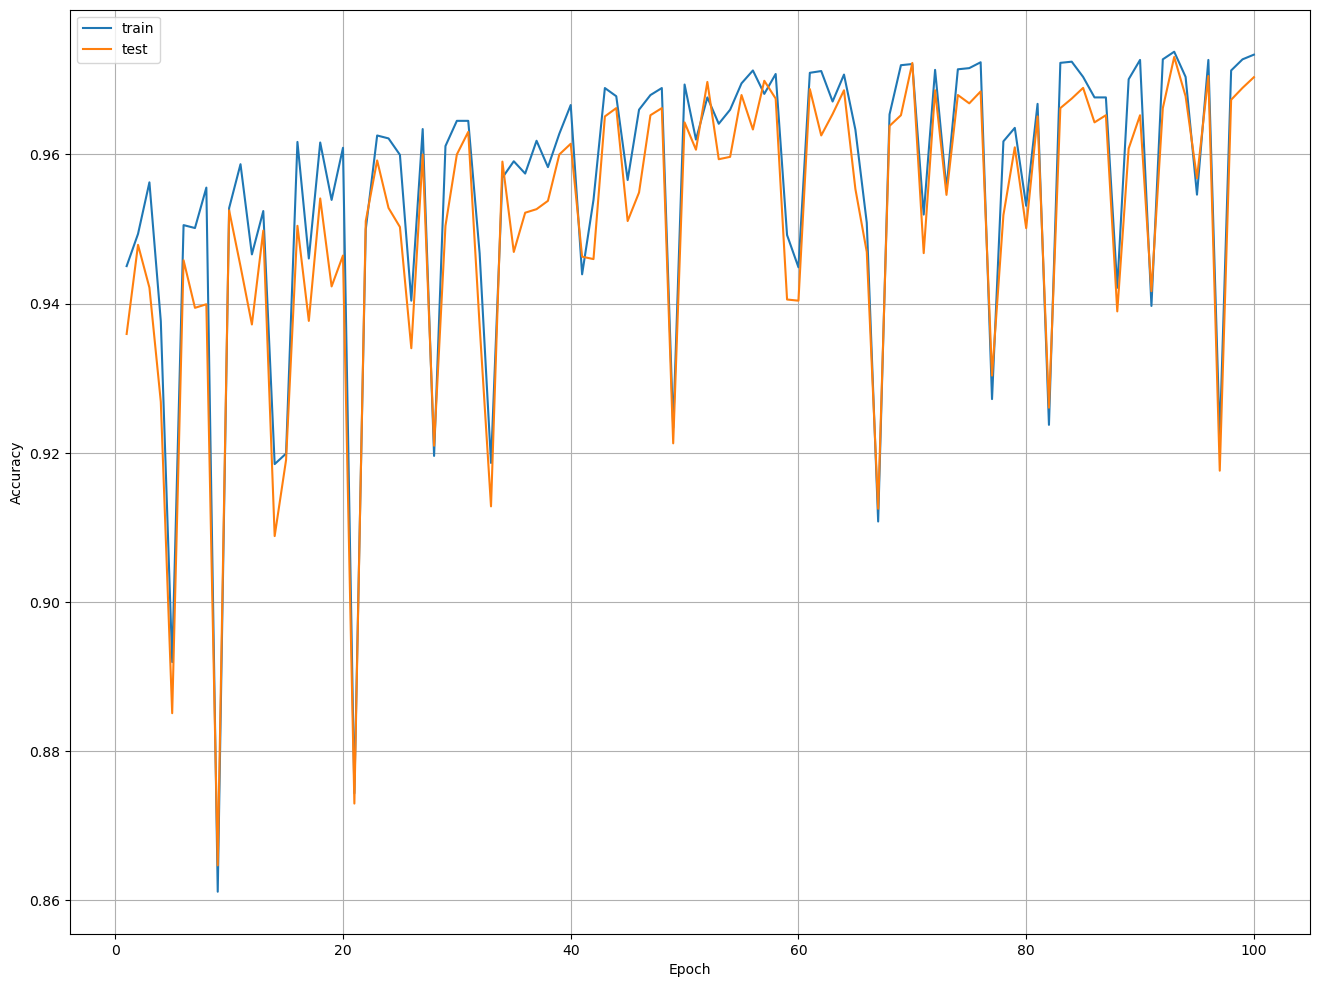

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
plt.plot(resultados.index, resultados.iloc[:,0], label="train")
plt.plot(resultados.index, resultados.iloc[:,1], label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## **_Parte 2_**

Repetir para una LSTM y una GRU con 2 capas ocultas y 5 neuronas.

In [29]:
scaler = MinMaxScaler(feature_range=(0,15))
X2 = scaler.fit_transform(shifted_df.iloc[:,1:])

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers = 1, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.hidden_layer = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)


        out, h = self.hidden_layer(x,(h0,c0))
        
        output = self.output_layer(out[:,-1,:])
        return output

In [47]:
input_size = 1 # Tamaño de la entrada
hidden_size = 5 # Tamaño de la capa oculta
output_size = 5 # Tamaño de la salida
num_layers = 2

model = LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers, output_size=output_size).to("cpu")

In [48]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X2, y, test_size=0.33, random_state=42)

In [50]:
X_train = torch.unsqueeze(torch.from_numpy(X_train_cpu).to(torch.float32), dim=-1).to("cpu")
X_test = torch.unsqueeze(torch.from_numpy(X_test_cpu).to(torch.float32), dim=-1).to("cpu")
y_train = torch.unsqueeze(torch.from_numpy(y_train_cpu).to(torch.float32), dim=-1).to("cpu")
y_test = torch.unsqueeze(torch.from_numpy(y_test_cpu).to(torch.float32), dim=-1).to("cpu")


In [51]:
train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [52]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    train_loss.append(train_one_epoch())
    val_loss.append(validate_one_epoch())
    print(f'Train Loss: {train_loss[epoch]:.4f} Validation Loss: {val_loss[epoch]:.4f}')

Epoch: 1


100%|██████████| 160/160 [00:00<00:00, 177.58it/s]


Train Loss: 54.4384 Validation Loss: 41.1210
Epoch: 2


100%|██████████| 160/160 [00:00<00:00, 160.48it/s]


Train Loss: 34.9148 Validation Loss: 27.5451
Epoch: 3


100%|██████████| 160/160 [00:01<00:00, 132.15it/s]


Train Loss: 24.5736 Validation Loss: 19.9553
Epoch: 4


100%|██████████| 160/160 [00:00<00:00, 176.74it/s]


Train Loss: 18.2335 Validation Loss: 15.0502
Epoch: 5


100%|██████████| 160/160 [00:01<00:00, 156.05it/s]


Train Loss: 13.9205 Validation Loss: 11.5414
Epoch: 6


100%|██████████| 160/160 [00:01<00:00, 155.75it/s]


Train Loss: 10.6953 Validation Loss: 8.9995
Epoch: 7


100%|██████████| 160/160 [00:01<00:00, 154.60it/s]


Train Loss: 8.4877 Validation Loss: 7.1167
Epoch: 8


100%|██████████| 160/160 [00:00<00:00, 199.05it/s]


Train Loss: 6.6802 Validation Loss: 5.6209
Epoch: 9


100%|██████████| 160/160 [00:00<00:00, 202.50it/s]


Train Loss: 5.2176 Validation Loss: 4.4231
Epoch: 10


100%|██████████| 160/160 [00:00<00:00, 180.49it/s]


Train Loss: 4.1016 Validation Loss: 3.4876
Epoch: 11


100%|██████████| 160/160 [00:00<00:00, 195.25it/s]


Train Loss: 3.1762 Validation Loss: 2.6836
Epoch: 12


100%|██████████| 160/160 [00:00<00:00, 167.48it/s]


Train Loss: 2.4536 Validation Loss: 2.0775
Epoch: 13


100%|██████████| 160/160 [00:00<00:00, 206.58it/s]


Train Loss: 1.8933 Validation Loss: 1.6383
Epoch: 14


100%|██████████| 160/160 [00:00<00:00, 200.69it/s]


Train Loss: 1.4813 Validation Loss: 1.2761
Epoch: 15


100%|██████████| 160/160 [00:00<00:00, 197.18it/s]


Train Loss: 1.1358 Validation Loss: 0.9938
Epoch: 16


100%|██████████| 160/160 [00:00<00:00, 200.84it/s]


Train Loss: 0.8852 Validation Loss: 0.7865
Epoch: 17


100%|██████████| 160/160 [00:00<00:00, 210.73it/s]


Train Loss: 0.6973 Validation Loss: 0.6226
Epoch: 18


100%|██████████| 160/160 [00:00<00:00, 199.56it/s]


Train Loss: 0.5592 Validation Loss: 0.5027
Epoch: 19


100%|██████████| 160/160 [00:00<00:00, 202.27it/s]


Train Loss: 0.4471 Validation Loss: 0.4128
Epoch: 20


100%|██████████| 160/160 [00:00<00:00, 206.19it/s]


Train Loss: 0.3757 Validation Loss: 0.3607


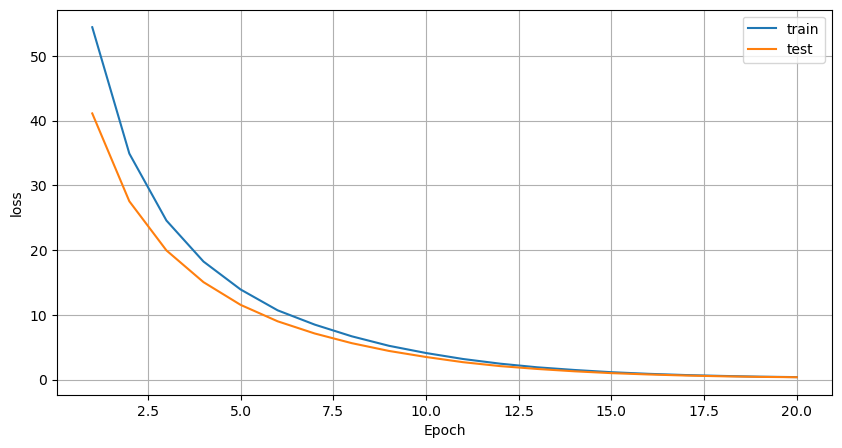

In [54]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,21), train_loss, label="train")
plt.plot(np.arange(1,21), val_loss, label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.grid()
plt.show()